# MLflow avanzado: Optimización de hiperparámetros y registro de modelos
 
En este notebook, exploraremos algunas de las funciones más avanzadas de MLflow, incluyendo:

-   **Optimización de hiperparámetros:** Usar Optuna para encontrar los mejores hiperparámetros para nuestro modelo y registrar los resultados en MLflow.
-   **Registro de modelos:** Registrar el mejor modelo en el Registro de Modelos de MLflow para versionado y despliegue.

In [1]:
import os
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
import pickle

## **Cargamos datos "procesados"**

In [2]:
df_jan = pd.read_parquet("data/processed/jan.parquet")
df_feb = pd.read_parquet("data/processed/feb.parquet")


## **Definir columnas a modelar**

In [3]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ["trip_distance"]

## Definir set de train y test

In [4]:
df_train = df_jan
df_val = df_feb

## **Preprocesar**

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

df_train = df_train.copy()
df_val   = df_val.copy()
df_train["categorical_dict"] = df_train[categorical].to_dict(orient="records")
df_val["categorical_dict"]   = df_val[categorical].to_dict(orient="records")

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", DictVectorizer(), "categorical_dict"),
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median")),
                          ("scaler", StandardScaler())]), numerical),
    ]
)

X_train = preprocessor.fit_transform(df_train)
y_train = df_train["duration"].values
X_val   = preprocessor.transform(df_val)
y_val   = df_val["duration"].values

## **Entrenar**

Antes de ejecutar lo siguiente correr en la terminal en la misma carpeta donde esta el notebook:

`mlflow server --backend-store-uri sqlite:///backend.db`



In [6]:
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [7]:
print(f"tracking URI: '{mlflow.get_tracking_uri()}'")

tracking URI: 'http://127.0.0.1:5000'


In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

experiment_name = "rf-nyc-taxi"
mlflow.set_experiment(experiment_name)

with mlflow.start_run():
    rf = RandomForestRegressor(n_estimators=100, random_state=0, max_depth=10)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 10)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric("rmse", rmse)

🏃 View run clumsy-fawn-403 at: http://127.0.0.1:5000/#/experiments/1/runs/f356deb3ab5349c2b729e00e2105a7f6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


## **Probando otro modelo**

In [9]:
import xgboost as xgb

with mlflow.start_run():
    xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric("rmse", rmse)

🏃 View run selective-cod-2 at: http://127.0.0.1:5000/#/experiments/1/runs/17ee89efd3f440859e243a7144c19c31
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


## **Probando autologgin**

In [13]:
import mlflow

experiment_name = "rf-nyc-taxi-autolog"
mlflow.set_experiment(experiment_name)
mlflow.autolog()

with mlflow.start_run():
    rf = RandomForestRegressor(n_estimators=100, random_state=0, max_depth=10)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 10)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric("rmse", rmse)


2025/09/03 21:24:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/09/03 21:24:20 WARNING mlflow.utils.autologging_utils: MLflow xgboost autologging is known to be compatible with 2.0.0 <= xgboost <= 3.0.2, but the installed version is 3.0.4. If you encounter errors during autologging, try upgrading / downgrading xgboost to a compatible version, or try upgrading MLflow.
2025/09/03 21:24:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2025/09/03 21:24:25 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run unleashed-wasp-528 at: http://127.0.0.1:5000/#/experiments/2/runs/a08c2f7a958346fc85961081092e58ec
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


## **Optimización de Hiperparametros**

## **¿Por qué es importante la optimización de hiperparámetros?**

En ML, los hiperparámetros son como los “ajustes” que le damos a nuestros modelos antes de entrenarlos. Cosas como la cantidad de árboles en un Random Forest, la profundidad máxima, o la tasa de aprendizaje en un modelo de boosting. Elegir bien estos valores puede marcar la diferencia entre un modelo mediocre y uno realmente bueno.

Optimizar los hiperparámetros no es solo cuestión de probar al azar: es un proceso sistemático para encontrar la mejor combinación posible, y así lograr que nuestro modelo aprenda mejor y generalice bien a datos nuevos. Si no los ajustamos, podemos quedarnos con un modelo que no aprovecha todo su potencial.

## **Usando Optuna**

Para facilitar este proceso, existen herramientas como **Optuna**, que nos ayudan a buscar automáticamente los mejores hiperparámetros de manera eficiente e inteligente. Optuna prueba diferentes combinaciones, aprende de los resultados y se enfoca en las opciones más prometedoras, ahorrándonos mucho tiempo y esfuerzo.

En resumen: dedicarle tiempo a la optimización de hiperparámetros, usando herramientas como Optuna, es clave para sacar el máximo provecho de nuestros modelos de ML.

<img src="optim.png">

In [ ]:
import optuna

mlflow.set_experiment("nyc-taxi-experiment-optuna")

def objective(trial):
    with mlflow.start_run():
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
            'max_depth': trial.suggest_int('max_depth', 1, 20, 1),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 6, 1),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4, 1),
            'random_state': 42,
            'n_jobs': -1
        }
        mlflow.log_params(params)

        rf = RandomForestRegressor(**params)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mlflow.log_metric("rmse", rmse)

    return rmse

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=100)

/Users/macano/Desktop/code_personal/MLOps_UdM/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-09-16 21:10:57,773] A new study created in memory with name: no-name-6265d10b-c88e-4757-a4ec-b777c253be76
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p

🏃 View run capricious-yak-7 at: http://127.0.0.1:5000/#/experiments/2/runs/57b52f0e49f84cd090c23999d4fd9fa5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
🏃 View run skittish-bird-7 at: http://127.0.0.1:5000/#/experiments/2/runs/1d19609d2b5b49ecb69f7ba364579440
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run powerful-rook-734 at: http://127.0.0.1:5000/#/experiments/2/runs/ce32e7c44a5d4f288a987f24fd2e36b2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
🏃 View run fortunate-auk-796 at: http://127.0.0.1:5000/#/experiments/2/runs/ac4ee44200494e1a9e1e334519eba163
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run intrigued-moth-298 at: http://127.0.0.1:5000/#/experiments/2/runs/c151d55432c14de1a7985e0e77f95e93
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
🏃 View run shivering-quail-397 at: http://127.0.0.1:5000/#/experiments/2/runs/83d5394158e14b3c942f1456c49bcd3a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run unruly-gull-240 at: http://127.0.0.1:5000/#/experiments/2/runs/014b0af94dad4a6f805f119b84c50775
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
🏃 View run dazzling-stag-95 at: http://127.0.0.1:5000/#/experiments/2/runs/7e5294bb088049d1ac21926c6d50b914
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run able-squirrel-436 at: http://127.0.0.1:5000/#/experiments/2/runs/67e8f0e47d624cdaa37ad7e672ef5ed6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
🏃 View run receptive-mare-768 at: http://127.0.0.1:5000/#/experiments/2/runs/63c560d00ac2447982bdc8fc227be6bd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run shivering-snipe-527 at: http://127.0.0.1:5000/#/experiments/2/runs/d764df4d7a1b4a87a56be16a4ce2f080
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run puzzled-shark-511 at: http://127.0.0.1:5000/#/experiments/2/runs/9de4d90f2d67479896ffca563754d449
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run enthused-eel-174 at: http://127.0.0.1:5000/#/experiments/2/runs/72a6e01e0b444613bf27ed0ae4c4afb6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run illustrious-worm-813 at: http://127.0.0.1:5000/#/experiments/2/runs/d522938cc37d446f958c216eabe94ed2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run luminous-moth-155 at: http://127.0.0.1:5000/#/experiments/2/runs/d5eaa15f8a2b4b408cf56f4e776b1a95
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run entertaining-ox-737 at: http://127.0.0.1:5000/#/experiments/2/runs/2eb38b7db985414f93feeacf38189bc9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run clean-snipe-643 at: http://127.0.0.1:5000/#/experiments/2/runs/8aff5e1873bb471c8c0b932a2e61f242
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run unique-newt-660 at: http://127.0.0.1:5000/#/experiments/2/runs/e51f45117dda422e91115720a97d961b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run carefree-horse-167 at: http://127.0.0.1:5000/#/experiments/2/runs/b4041f1e93824c1da1fa327684580477
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run agreeable-sow-851 at: http://127.0.0.1:5000/#/experiments/2/runs/88f2d0bc282444c38d2104ca9dff4fde
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run trusting-zebra-521 at: http://127.0.0.1:5000/#/experiments/2/runs/824f205530da4250bf70416cbe615ab8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run grandiose-donkey-395 at: http://127.0.0.1:5000/#/experiments/2/runs/3a5c37ce0cca4c64a2e7c8b1c8befd61
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run sedate-zebra-735 at: http://127.0.0.1:5000/#/experiments/2/runs/72656ab4d89c47f2a26e058feb9b951a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run funny-bug-454 at: http://127.0.0.1:5000/#/experiments/2/runs/0dd5d7f1ba534d07bbbaa7952bd35639
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run overjoyed-hare-757 at: http://127.0.0.1:5000/#/experiments/2/runs/68c09a9785b74984bcdfcb39dab2c128
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run masked-pig-718 at: http://127.0.0.1:5000/#/experiments/2/runs/3586bfc368de4d9c9de7826628f61b97
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run useful-mouse-425 at: http://127.0.0.1:5000/#/experiments/2/runs/4be29559203e49ac97621379569a160e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run auspicious-bass-838 at: http://127.0.0.1:5000/#/experiments/2/runs/c818b28eceb6471680e66acb8643828f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run unique-hog-112 at: http://127.0.0.1:5000/#/experiments/2/runs/dd38708f1c214c4e908aaac326738178
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run agreeable-croc-393 at: http://127.0.0.1:5000/#/experiments/2/runs/047b44f6354740c8a1f630d60b0549af
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run skittish-wasp-750 at: http://127.0.0.1:5000/#/experiments/2/runs/6b44f112c984408982480193278a5701
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run bold-shrike-460 at: http://127.0.0.1:5000/#/experiments/2/runs/1295ca293b5e42e4a8da19cf0ecd9f84
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run adaptable-snake-928 at: http://127.0.0.1:5000/#/experiments/2/runs/e9a8ffb2d5d6476694cf8026be1fbd7d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run bittersweet-yak-306 at: http://127.0.0.1:5000/#/experiments/2/runs/461cd33abd0d4051be9531df1e6b7c75
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run honorable-swan-799 at: http://127.0.0.1:5000/#/experiments/2/runs/788a771750c341c5b721a793909cf445
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run luxuriant-crow-322 at: http://127.0.0.1:5000/#/experiments/2/runs/7f166559bc464728add905b81699ae1c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run unequaled-newt-283 at: http://127.0.0.1:5000/#/experiments/2/runs/a049666e11e4445294e6a73485cbabd6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run polite-auk-52 at: http://127.0.0.1:5000/#/experiments/2/runs/eaf4373df81045ac818e6627faf8fd2e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run tasteful-shad-964 at: http://127.0.0.1:5000/#/experiments/2/runs/94554ee0088f4c85940e521ab6078c1a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
🏃 View run thundering-loon-94 at: http://127.0.0.1:5000/#/experiments/2/runs/6a11b7cb99774466b0d411708571ee38
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run resilient-stoat-286 at: http://127.0.0.1:5000/#/experiments/2/runs/e3d7aaa227584798ab0e8a149fb4b2ec
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run gifted-quail-275 at: http://127.0.0.1:5000/#/experiments/2/runs/ab3a9cb2116046308fffc29f9a131073
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run mercurial-fly-561 at: http://127.0.0.1:5000/#/experiments/2/runs/2c78ce8926f84bfe9795b909e9f4dce8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run loud-perch-200 at: http://127.0.0.1:5000/#/experiments/2/runs/3553793f471f48d6a461814c310acae1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run whimsical-yak-234 at: http://127.0.0.1:5000/#/experiments/2/runs/2f7eb85672ce4f5bb008d95a472ccf7a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run amazing-cod-52 at: http://127.0.0.1:5000/#/experiments/2/runs/9eafb330c5974638873e59034a2129f0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run fearless-hawk-183 at: http://127.0.0.1:5000/#/experiments/2/runs/b3833d0081254a9ba3142e71b0f65ae5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run incongruous-owl-672 at: http://127.0.0.1:5000/#/experiments/2/runs/0ccba9de0e634439ad1cf84481e87bfe
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run tasteful-ape-295 at: http://127.0.0.1:5000/#/experiments/2/runs/9bfc2d6595694a718a2a65d547645935
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run polite-croc-113 at: http://127.0.0.1:5000/#/experiments/2/runs/c2bf0d88952449c0bbfdf2a8a50bea38
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run inquisitive-fish-682 at: http://127.0.0.1:5000/#/experiments/2/runs/68207e8b280f46658585c3fe91d9d7c2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run upset-wasp-586 at: http://127.0.0.1:5000/#/experiments/2/runs/d1f8c2174a154e6e9302c17bfed8431d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run brawny-moth-512 at: http://127.0.0.1:5000/#/experiments/2/runs/8ccb681e77974362baac00ba6fdb5cab
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run stately-dove-727 at: http://127.0.0.1:5000/#/experiments/2/runs/834fc7d7a23b4ee7b9673d45213fb666
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
🏃 View run grandiose-robin-113 at: http://127.0.0.1:5000/#/experiments/2/runs/43c051bf2397424e9f68c5315f910d4f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run casual-seal-187 at: http://127.0.0.1:5000/#/experiments/2/runs/224b204f8f6e4e469a7d24a592fd8a3d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run unruly-pig-957 at: http://127.0.0.1:5000/#/experiments/2/runs/4afbbed854cc4532831ffb07c456b764
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
🏃 View run melodic-shoat-5 at: http://127.0.0.1:5000/#/experiments/2/runs/82887d8b09d24e6ab90588c078f6906e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run adorable-goat-611 at: http://127.0.0.1:5000/#/experiments/2/runs/3449cc6edda349d2a21642b9e872117d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run bold-lark-604 at: http://127.0.0.1:5000/#/experiments/2/runs/e9062dbee4f4425dae6360f675b3a6ef
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run adorable-boar-241 at: http://127.0.0.1:5000/#/experiments/2/runs/da75edc002384c2d86c1f538aa26ccca
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run worried-dolphin-551 at: http://127.0.0.1:5000/#/experiments/2/runs/fcfccf060d6145fcad48520ef67f3a9c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run stylish-calf-409 at: http://127.0.0.1:5000/#/experiments/2/runs/3dfff6f10b2e423f97219d3f06dac02a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run amusing-snail-882 at: http://127.0.0.1:5000/#/experiments/2/runs/e3a7ccbeb1ab4fd782f772fd65aa886e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run chill-shrew-252 at: http://127.0.0.1:5000/#/experiments/2/runs/328bbd5584274768a0ca5ef49d660f93
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run stylish-pug-701 at: http://127.0.0.1:5000/#/experiments/2/runs/2ed64ce2e8a44e1bba68265f9d35a81a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run delicate-hound-60 at: http://127.0.0.1:5000/#/experiments/2/runs/a3fb52ac574f4be4821eb34003556aca
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run learned-gnat-225 at: http://127.0.0.1:5000/#/experiments/2/runs/b9ab991f364741619b25314c8a2544c8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run bright-colt-82 at: http://127.0.0.1:5000/#/experiments/2/runs/a993e1ead99c4ca4aad0c64566de53d2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
🏃 View run resilient-lynx-695 at: http://127.0.0.1:5000/#/experiments/2/runs/62890b9208e54649827d7b07ca0ad4dd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run wise-calf-562 at: http://127.0.0.1:5000/#/experiments/2/runs/a9b4e982cc894db2ad495627b34b46fe
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run glamorous-grouse-953 at: http://127.0.0.1:5000/#/experiments/2/runs/363dba66ccbe402f8c8c4422ddd28432
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run adventurous-bass-288 at: http://127.0.0.1:5000/#/experiments/2/runs/4e7ab9d74cbe426ca34c59545844ac05
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run luxuriant-tern-612 at: http://127.0.0.1:5000/#/experiments/2/runs/eb58e6b1c29c4736b427a4c88925f24d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run redolent-mule-834 at: http://127.0.0.1:5000/#/experiments/2/runs/3e4c32bc516d4138b4ba2cc095538335
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run useful-hound-932 at: http://127.0.0.1:5000/#/experiments/2/runs/4ec990e02e7446859b15d9896574a64f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run learned-turtle-487 at: http://127.0.0.1:5000/#/experiments/2/runs/03e0da5d93a84f6ea1026fd0e4291a0f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run bold-ox-981 at: http://127.0.0.1:5000/#/experiments/2/runs/454d573f7a5d4d7ab95a0f405d4908e9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
🏃 View run amusing-gull-359 at: http://127.0.0.1:5000/#/experiments/2/runs/5b9043daac1c493896e1d872bcce95c3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run stately-stork-674 at: http://127.0.0.1:5000/#/experiments/2/runs/f086e8839a104212ba30fabba9119454
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


[I 2025-09-16 21:11:19,869] Trial 80 finished with value: 5.046753448712581 and parameters: {'n_estimators': 42, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 73 with value: 5.029438300335224.


🏃 View run secretive-skunk-176 at: http://127.0.0.1:5000/#/experiments/2/runs/aba359142a024109a7aad18664734367
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run defiant-duck-665 at: http://127.0.0.1:5000/#/experiments/2/runs/405f0ab4515f4a4ea8549ec5eb607969
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run bald-fox-450 at: http://127.0.0.1:5000/#/experiments/2/runs/68f94c0061d1486ba17451ba39bc4b74
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run polite-moose-585 at: http://127.0.0.1:5000/#/experiments/2/runs/20bf908ff8ad43de87736802c6755f9a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run thundering-owl-29 at: http://127.0.0.1:5000/#/experiments/2/runs/0283c6bf92214539ae4ae3e923f60722
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run whimsical-toad-90 at: http://127.0.0.1:5000/#/experiments/2/runs/ad95c73f41814adf8efa4ec14c3407db
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run treasured-hog-571 at: http://127.0.0.1:5000/#/experiments/2/runs/96bad16080aa409997407f5fc9f34e4e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run painted-mule-582 at: http://127.0.0.1:5000/#/experiments/2/runs/348f026589a84e99af19089ae74817f8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run capricious-trout-251 at: http://127.0.0.1:5000/#/experiments/2/runs/02335f0291ce4b9cbe273d852930b11e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run flawless-calf-808 at: http://127.0.0.1:5000/#/experiments/2/runs/511ed6179d1d4cfd93cb886ec4c28ba9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run luxuriant-colt-328 at: http://127.0.0.1:5000/#/experiments/2/runs/4afcbeb7928d4a3998d43bc87e39a821
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run traveling-hog-451 at: http://127.0.0.1:5000/#/experiments/2/runs/a4e2d183753e4b6c9dc31c48bb7e0ce3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run enthused-grouse-839 at: http://127.0.0.1:5000/#/experiments/2/runs/0eb0c11e2cb54db4975174c97e087d3d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run welcoming-turtle-356 at: http://127.0.0.1:5000/#/experiments/2/runs/7ef44636f5bd4b288541353cd600451d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run honorable-grub-969 at: http://127.0.0.1:5000/#/experiments/2/runs/410c07956bee499f9bbf1902d560ea1d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run resilient-skunk-956 at: http://127.0.0.1:5000/#/experiments/2/runs/ec6de2babbd7443b9dde4904006594e9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run caring-tern-524 at: http://127.0.0.1:5000/#/experiments/2/runs/95b422db4f1045a6a0549aa99718b6ad
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run nervous-bass-38 at: http://127.0.0.1:5000/#/experiments/2/runs/f06d7dd2eb364248bed1dd175d15c0a9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run bustling-sheep-681 at: http://127.0.0.1:5000/#/experiments/2/runs/8f0d5226f92645c19d28230553b81823
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_80721/4268162343.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the k

🏃 View run tasteful-fish-581 at: http://127.0.0.1:5000/#/experiments/2/runs/36f99e7110404312910ae6f358fd260a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


## **Explorando la MLflow UI**

Ahora que hemos ejecutado la optimización, vamos a explorar la interfaz de MLflow:

1. **Experimentos**: Ve a la pestaña "Experiments" para ver todos los experimentos
2. **Runs**: Cada trial de Optuna aparece como un run individual
3. **Métricas**: Compara el RMSE de todos los trials
4. **Parámetros**: Ve cómo varían los hiperparámetros
5. **Model Registry**: Encuentra el modelo registrado en "Models"

### **Qué buscar en la UI:**
- El run con el menor RMSE (mejor modelo)
- La evolución de las métricas a lo largo de los trials
- La importancia de cada hiperparámetro
- Los artefactos del modelo registrado

## **Mejor modelo**

Cuando tenemos el mejor modelo, lo entrenamos de nuevo para despues usarlo.

In [11]:
# Analyze the best trial
print(f"Best trial: {study.best_trial.number}")
print(f"Best value (RMSE): {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Train the best model
best_params = study.best_params
best_model = RandomForestRegressor(**best_params)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_val)
rmse_best = np.sqrt(mean_squared_error(y_val, y_pred_best))

print(f"\nBest model RMSE: {rmse_best:.4f}")

Best trial: 90
Best value (RMSE): 5.0236
Best params:
  n_estimators: 49
  max_depth: 15
  min_samples_split: 8
  min_samples_leaf: 2

Best model RMSE: 5.0275


## **Visualizando la optimización de optuna**

/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_38977/602149405.py:6: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

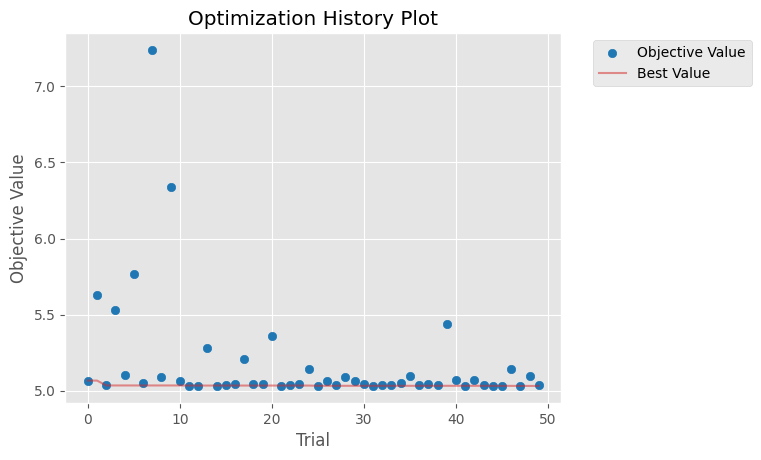

In [17]:
# Visualize optimization history
import matplotlib.pyplot as plt


# Optimization history
optuna.visualization.matplotlib.plot_optimization_history(study)



/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_38977/82623574.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)
2025/09/03 22:02:57 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5d2d05490db74d9e8f05af63750e2eba', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/09/03 22:02:59 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run glamorous-elk-818 at: http://127.0.0.1:5000/#/experiments/3/runs/5d2d05490db74d9e8f05af63750e2eba
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

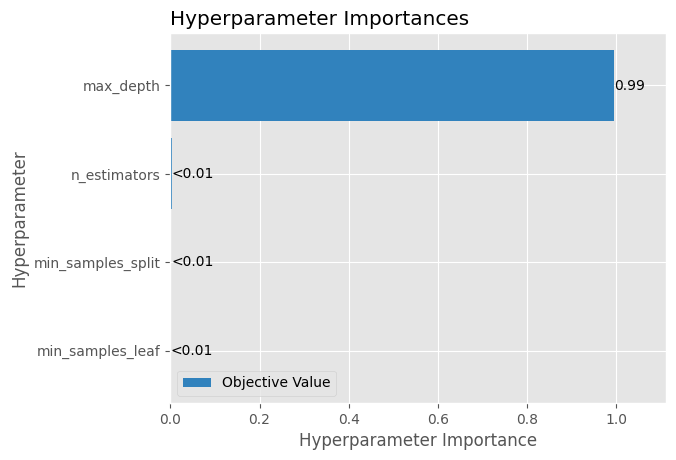

In [19]:
optuna.visualization.matplotlib.plot_param_importances(study)


# **Usando el model registry para guardar el mejor modelo y "ponerlo" en producción**

Podemos usar autlog de sklearn para captar la mayor cantidad de parametros y asi tener un modelo altamente replicable

La importancia del model registry es ya no solamente pensar en la experimentación, sino que al final, después de haber encontrado el mejor modelo pushearlo a nuestro model registry y poder usarlo en producción.

In [20]:
# Register the best model
with mlflow.start_run(run_id=study.best_trial.user_attrs.get('mlflow_run_id')):
    # Log the model
    mlflow.sklearn.log_model(
        best_model, 
        "model",
        registered_model_name="nyc-taxi-rf-optimized"
    )
    
    # Log preprocessing pipeline
    mlflow.sklearn.log_model(
        preprocessor, 
        "preprocessor",
        registered_model_name="nyc-taxi-preprocessor"
    )

2025/09/03 22:13:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/03 22:13:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/09/03 22:13:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'nyc-taxi-rf-optimized'.
2025/09/03 22:13:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: nyc-taxi-rf-optimized, version 1
Created version '1' of model 'nyc-taxi-rf-optimized'.
2025/09/03 22:13:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/03 22:13:15 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/09/0

🏃 View run overjoyed-wasp-649 at: http://127.0.0.1:5000/#/experiments/3/runs/25696e3de5aa4e53a9ddd4efcb225ca2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


Created version '1' of model 'nyc-taxi-preprocessor'.
